# Quickstart: 簡単な設定でのシミュレーションと人工データセット (データ収集)
このノートブックは簡単なシミュレーション環境から集められたログデータの可視化の例を紹介します．

特に、以下の3つの順番で解説していきます: 

0. (シミュレーション環境の設定とオンライン強化学習)
1. 離散行動空間における事例
2. 連続行動空間における事例
3. 複数のデータ収集方策方策やランダムシードによるログデータの収集


このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [12]:
# SCOPE-RL モジュールのインポート
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig

# その他のライブラリのインポート
import gym
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

In [3]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345
random_ = check_random_state(random_state)

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 0. (シミュレーション環境の設定とオンライン強化学習)
まず初めに，今回用いる簡単な環境設定について紹介します．

#### 強化学習での環境のセットアップ
今回は簡単なシミュレーション環境上で，方策の獲得する累積報酬を最大化する問題を考えます．

この強化学習の問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します．
- `状態`: 状態観測（POMDPの場合は観測ノイズが発生）．
- `行動`: 強化学習エージェント (方策) により選択された行動．
- `報酬`: 状態と行動に応じて観測される報酬．

より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart/basic/basic_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env.ipynb).


In [7]:
# 環境のセットアップ
env = BasicEnv(random_state=random_state)

In [15]:
# ランダムに行動を選択するエージェントを定義
agent = OnlineHead(
    ContinuousRandomPolicyConfig().create(device=device),
    name="random",
)
agent.build_with_env(env)

In [16]:
# 環境とエージェントの相互作用
# 6行で強化学習の相互作用を記述できる
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [17]:
# 状態
print(obs.shape)
print(obs)

(5,)
[ 0.37801347 -0.60047514 -0.16326933  0.57911164 -0.36675368]


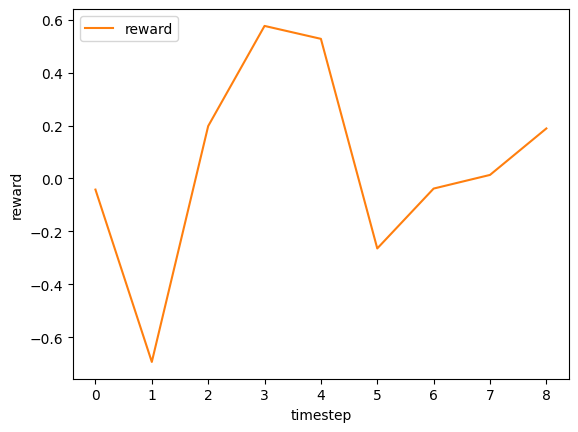

In [18]:
# ランダムエージェントでの報酬の推移を可視化
obs, info = env.reset()
done = False
reward_list = []

while not done:
    action = agent.sample_action_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    reward_list.append(reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('reward')
ax1.legend(loc='upper left')
plt.show()

## 1. 離散行動空間
ま図は行動空間が離散の場合にデータ収集方策からどのようにデータを収集するかを紹介します．

ここでは2つの手順を必要とします．
1. ベースとなる決定的 (非確率的) な方策を学習する．
2. 決定的な方策を用い確率的な方策を定義する．

決定的な方策を学習する際は[d3rlpy](https://github.com/takuseno/d3rlpy)を利用します．

In [19]:
# 離散行動空間に対する標準的な環境
env = gym.make("BasicEnv-discrete-v0")

In [20]:
# データ生成のためのベースとなる決定的方策の学習
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# モデル
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# 再生バッファ
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

# 探索
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [16]:
# モデルの保存
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [22]:
# モデルのリロード
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-07-22 15:27:33 [warning  ] Parameters will be reinitialized.


### 1.1. Epsilon-Greedy 方策

ここでは学習した決定的な方策から確率的方策を定義します．

今回用いるepsilon-greedy方策では，$1 - \epsilon$の確率で貪欲に行動を選択し，$\epsilon$の確率でランダムな行動を選択します．

$$\pi(a | s) := (1 - \epsilon) * \pi_{\mathrm{det}}(a | s) + \epsilon / |\mathcal{A}|,$$

ここで$a \in \mathcal{A}$ は行動，$s \in \mathcal{S}$は状態，$\pi$ は決定的なベース方策$\pi_{\mathrm{det}}$を用いて定義された確率的方策です．

このepsilon-greedy方策をデータ収集方策として人工データを生成しますが、その際に用いる`SyntheticDataset` は以下の引数を持っています:
- `env`: 強化学習の（シミュレーション）環境．
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）．

In [23]:
# ddqn方策を確率的なデータ収集方策に変えます
from scope_rl.policy import EpsilonGreedyHead

behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # ランダムな行動をとる確率
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [ ]:
# データ生成
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

In [25]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.00305434,  0.25886564,  0.94683458, -0.18441597, -0.04974207],
        [ 0.09209668,  0.18060315, -0.96557628, -0.16297735,  0.00123719],
        ...,
        [-0.32659665, -0.4457801 ,  0.12418311, -0.55321285,  0.61085909],
        [ 0.91297429, -0.08570925,  0.24184222, -0.15626001,  0.27609242],
        [-0.38500003,  0.06259195,  0.51752316, -0.76154405,  0.00881301]]),
 'action': array([6, 1, 6, ..., 8, 6, 5]),
 'reward': array([ 0.85571015, -0.27916946,  0.63759116, ...,  0.03190668,
         0.79813161,  0.60196688]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.73, 0.03, 0.73, ..

### 1.2. ソフトマックス方策
次に，epsilon-greedyの代わりに`SoftmaxHead`を用いて確率的なデータ収集方策を定義します．

ソフトマックス方策は，状態と行動のペア$(s, a)$が与えられた時に価値を推定するQ関数$Q(s, a)$を用い、以下のように確率的に行動を選択します．

$$\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)},$$

$\tau$ は方策のエントロピーを調整する温度パラメータです．

In [26]:
# ddqn方策を確率的なデータ収集方策に変えます

from scope_rl.policy import SoftmaxHead

behavior_policy = SoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # 温度パラメータ
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [ ]:
# データ生成
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

In [28]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.64485759,  0.51071168, -0.52750824,  0.03342947, -0.20964208],
        [ 0.06101586, -0.03246848, -0.82748705, -0.37659153, -0.41069071],
        ...,
        [ 0.16542329,  0.19496503, -0.86782052, -0.01134997, -0.42589025],
        [-0.3159583 , -0.38225619, -0.03900763, -0.55802578, -0.66418085],
        [-0.18653574, -0.51963184,  0.68105195, -0.21024438,  0.4326115 ]]),
 'action': array([2, 2, 9, ..., 6, 5, 7]),
 'reward': array([0.39970333, 0.17633499, 0.35529554, ..., 0.5291534 , 0.43462625,
        0.37790305]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.13459426, 0.05894504, 0.

離散行動空間でのオフライン強化学習やオフ方策評価 (OPE) に関しては[examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb)を参照してください.

オフ方策評価 (OPE) や オフ方策選択 (OPS) に関する発展的なトピックは[examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_advanced.ipynb)を参照してください.

## 2. 連続行動空間
まずは離散行動の場合と同様に，ベースとなる決定的な方策を学習します．

In [29]:
# 連続行動空間に対する標準的な環境
env = gym.make("BasicEnv-continuous-v0")

In [30]:
# データ生成のベースとなる決定的方策の学習
from d3rlpy.algos import SACConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer

# モデル
sac = SACConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   
        maximum=env.action_space.high,  
    ),
).create(device=device)

# 再生バッファ
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [35]:
# モデルの保存
sac.save_model("d3rlpy_logs/sac.pt")

In [34]:
# モデルのリロード
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

2023-07-22 15:41:41 [warning  ] Parameters will be reinitialized.


### 2.1. ガウス方策

ここでは，学習した決定的方策にノイズを加えることで確率的方策を定義します． 

今回は，`BasicEnv`の有界な行動空間に対応するために，`TruncatedGaussianHead`を利用します．
この方策は決定的方策$\pi(s)$の選ぶ行動に応じて, 切断ガウス分布から行動をサンプリングします．
$$a \sim Truncnorm(\pi(s), \sigma),$$

ここで$\sigma$ノイズの大きさを表しています．

行動空間が有界でない時は, `GaussianHead`を利用できます．

In [37]:
from scope_rl.policy import TruncatedGaussianHead

behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,  # 行動空間の下限
    maximum=env.action_space.high,  # 行動空間の上限
    sigma=np.array([1.0]),  # ガウシアン分布のノイズスケール
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [ ]:
# データ収集
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)
logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

In [39]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 3,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.07780383, -0.17498141,  0.97063136,  0.07659025,  0.12384171],
        [-0.27403345,  0.53195699,  0.48746454,  0.53854036,  0.3380533 ],
        ...,
        [-0.13130183, -0.01022507, -0.93221219, -0.09531446, -0.32334327],
        [ 0.03276998,  0.3246122 , -0.57501869,  0.21644226, -0.71837268],
        [-0.13463518, -0.40077374, -0.77812761, -0.40760688, -0.22277304]]),
 'action': array([[-0.32848067, -0.71076631,  0.33065364],
        [-0.05175279,  0.36956034, -0.96124512],
        [ 0.50680347, -0.75081392,  0.264312  ],
        ...,
        [ 0.85193194,  0.8514727 , -0.59952989],
        [ 0.42420719, -0.09306683,  0.68725738],
        [ 0.61809302, -0.99855857,

オフライン強化学習やオフ方策評価 (OPE) に関しては[examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_basic.ipynb)を参照してください．

オフライン強化学習 (OPE) や オフ方策評価 (OPS) に関する発展的なトピックは[examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_advanced.ipynb)を参照してください．

## 3. 複数のデータ収集方策方策やランダムシードによるログデータの収集
最後に，複数のデータ収集方策とランダムシードを用いてログデータを収集する際の効率的な実装方法を紹介します．

離散行動の場合を紹介しますが，連続行動の場合も同様に扱うことができます．

In [40]:
# 離散行動空間に対する標準的な環境
env = gym.make("BasicEnv-discrete-v0")

In [41]:
# いくつかのデータ収集方策を定義
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,  # ランダム行動を選択する確率
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # ランダム行動を選択する確率
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,  # ランダム行動を選択する確率
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,  # ランダム行動を選択する確率
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [42]:
# データクラスの初期化
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
logged_datasets = dataset.obtain_episodes(
    behavior_policies=behavior_policies,
    n_datasets=2,  # random_stateの数
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)

In [44]:
logged_dataset = logged_datasets.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.46692103, -0.60091272,  0.12748286,  0.10612129,  0.62719618],
        [ 0.00305434,  0.25886564,  0.94683458, -0.18441597, -0.04974207],
        [-0.13005656, -0.04117723,  0.18071338, -0.53347445,  0.81494626],
        ...,
        [ 0.0840951 , -0.18714296,  0.31295643, -0.82369983,  0.42600749],
        [ 0.64171577,  0.10529459,  0.17897809, -0.2985224 ,  0.67525191],
        [ 0.39900535,  0.04439272, -0.68787737, -0.60115584,  0.06527166]]),
 'action': array([6, 6, 4, ..., 8, 4, 6]),
 'reward': array([ 0.85571015,  0.80607969,  0.83013847, ..., -0.04520555,
         0.78231063,  0.75780294]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.91, 0.91, 0.91, ..

複数のデータを用いたオフライン強化学習やオフ方策評価 (OPE) に関しては[examples/quickstart/basic/basic_synthetic_discrete_multiple.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_discrete_multiple.ipynb)（離散行動空間），[examples/quickstart/basic/basic_synthetic_continuous_multiple.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_multiple.ipynb)（連続行動空間）を参照してください．

## 参考文献

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.